In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
# defining the network
class Net(nn.Module):
  def __init__(self, n):
    super().__init__()
    # an affine operation: y = Wx + b
    torch.manual_seed(7)
    self.fc1 = nn.Linear(n, n, bias=False)
    self.fc1.weight.data.normal_(0, 1/np.sqrt(n))
    torch.manual_seed(7)
    self.fc2 = nn.Linear(n, 1, bias=False)
    self.fc2.weight.data.normal_(0, 1/np.sqrt(n))

  def forward(self, x):
    x = self.fc1(x)
    z_hat = self.fc2(x)
    return z_hat

In [3]:
def SGDvsADAM_loss(n):
  z_target = torch.ones(1)
  torch.manual_seed(12)
  x_input = torch.randn(n)

  loss_w1_SGD=0.0
  loss_w2_SGD=0.0 
  loss_w1_Adam=0.0
  loss_w2_Adam=0.0

  net = Net(n)
  w1_init = net.fc1.weight.clone()
  w2_init = net.fc2.weight.clone()
  
  loss_f = nn.MSELoss()
  
  steps = 200
  alpha_SDG = 0.5e-2
  lr_SGD = alpha_SDG*(float(n)**(-1))
  alpha_Adam = 0.2e-1
  lr_Adam = alpha_Adam*(float(n)**(-1.5))
  optimizer_SGD = optim.SGD(net.parameters(), lr = lr_SGD) 
  optimizer_ADAM = optim.Adam(net.parameters(), lr = lr_Adam)
  loss_n_SGD = []
  loss_n_Adam = []

  # ~~~~~SGD~~~~~
  # training with SGD
  for i in range(steps):
    optimizer_SGD.zero_grad()
    z_hat = net.forward(x_input)
    loss = loss_f(z_hat, z_target)
    loss.backward()
    optimizer_SGD.step()
    loss_n_SGD.append(float(loss))
  
  w1_final_SGD = net.fc1.weight.clone()
  
  # w1-init, w2-final
  with torch.no_grad():
    net.fc1.weight[:] = w1_init
    #second layer is already w2_final
    z_hat = net.forward(x_input)
    loss_w1_SGD += loss_f(z_hat, z_target)
                
  # w1-final, w2-init
  with torch.no_grad():
    net.fc1.weight[:] = w1_final_SGD
    net.fc2.weight[:] = w2_init
    z_hat = net.forward(x_input)
    loss_w2_SGD += loss_f(z_hat, z_target)


  #initializing nn for Adam
  with torch.no_grad():
    net.fc1.weight[:] = w1_init
    net.fc2.weight[:] = w2_init

  
  # ~~~~~Adam~~~~~
  # training with Adam
  for i in range(steps):
    optimizer_ADAM.zero_grad()
    z_hat = net.forward(x_input)
    loss = loss_f(z_hat, z_target)
    loss.backward()
    optimizer_ADAM.step()
    loss_n_Adam.append(float(loss))

  w1_final_Adam = net.fc1.weight.clone()
  
  # w1-init, w2-final
  with torch.no_grad():
    net.fc1.weight[:] = w1_init
    #second layer is already w2_final
    z_hat = net.forward(x_input)
    loss_w1_Adam += loss_f(z_hat, z_target)
                
  # w1-final, w2-init
  with torch.no_grad():
    net.fc1.weight[:] = w1_final_Adam
    net.fc2.weight[:] = w2_init
    z_hat = net.forward(x_input)
    loss_w2_Adam += loss_f(z_hat, z_target)

  return loss_w1_SGD, loss_w2_SGD, loss_w1_Adam, loss_w2_Adam, loss_n_SGD , loss_n_Adam

In [4]:
l1_loss_SGD=[]
l2_loss_SGD=[]
l1_loss_ADAM=[]
l2_loss_ADAM=[]
final_losses_SGD = []
final_losses_Adam = []
loss_n_SGD_trajectory = []
loss_n_Adam_trajectory = []
n_sizes = (100,500,1000,2000,3000,4000,5000)

for n in tqdm(n_sizes):

  loss_SGD_L1, loss_SGD_L2, loss_ADAM_L1, loss_ADAM_L2, loss_n_SGD , loss_n_Adam = SGDvsADAM_loss(n)
  l1_loss_SGD.append(loss_SGD_L1)
  l2_loss_SGD.append(loss_SGD_L2)
  l1_loss_ADAM.append(loss_ADAM_L1)
  l2_loss_ADAM.append(loss_ADAM_L2)
  loss_n_SGD_trajectory.append(loss_n_SGD)
  loss_n_Adam_trajectory.append(loss_n_Adam)


100%|██████████| 7/7 [06:13<00:00, 53.31s/it]


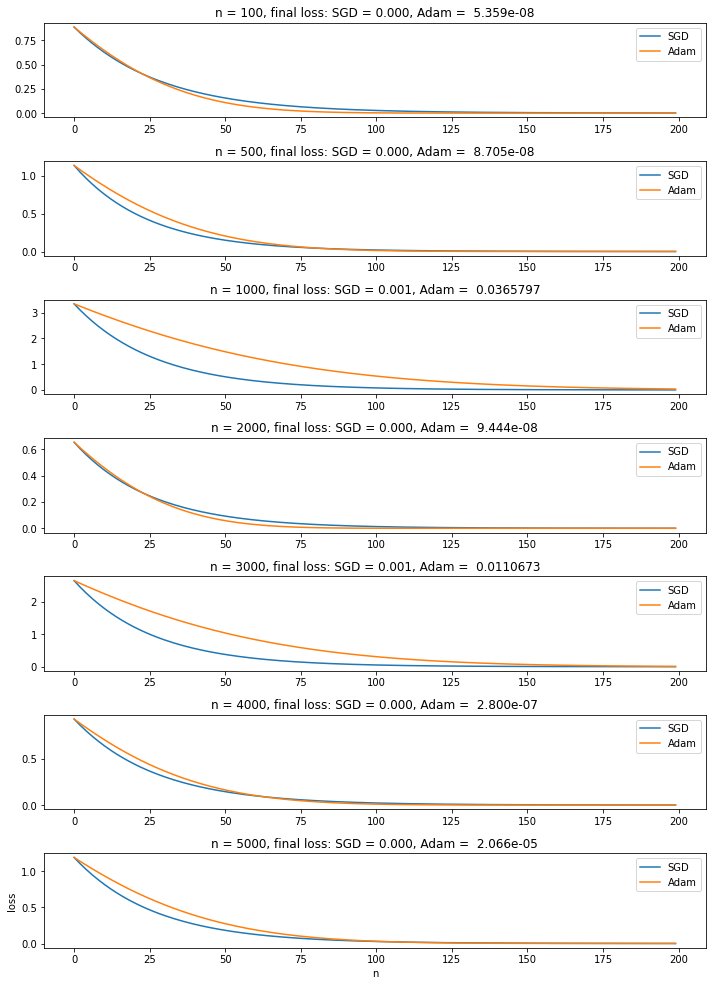

In [10]:
final_losses_SGD = []
final_losses_Adam = []
fig = plt.figure(figsize=(10, 15))
steps = np.arange(0,200,1)
axes = fig.subplots(len(n_sizes), 1)
for i,n in enumerate(n_sizes):
  ax1 = axes[i]
  plt.ylabel('loss')
  plt.xlabel('n')
  loss_SGD = loss_n_SGD_trajectory[i]
  loss_Adam = loss_n_Adam_trajectory[i]
  ax1.plot(steps, loss_SGD, label = 'SGD')
  ax1.plot(steps, loss_Adam, label = 'Adam')
  STR = "n = " + str(n) + ", final loss: SGD = " + str(loss_SGD[199])[:5] +  ", Adam =  " + str(loss_Adam[199])[:5] + str(loss_Adam[199])[-4:]
  ax1.set_title(STR, fontsize=12)
  ax1.legend()
  final_losses_SGD.append(loss_SGD[199])
  final_losses_Adam.append(loss_Adam[199])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

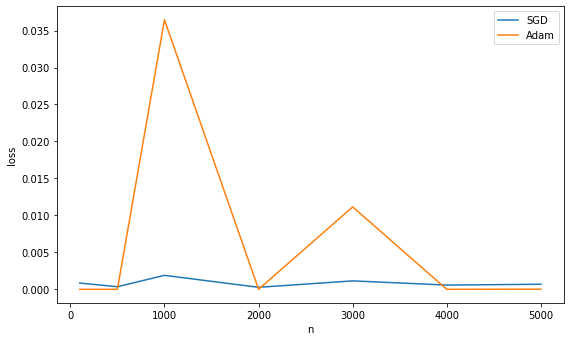

In [6]:
#plotting losses after training
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(221)
plt.ylabel('loss')
plt.xlabel('n')
ax1.plot(n_sizes, final_losses_SGD, label = 'SGD')
ax1.plot(n_sizes, final_losses_Adam, label = 'Adam')
ax1.legend()




Text(0.5, 0.98, 'Losses vs n')

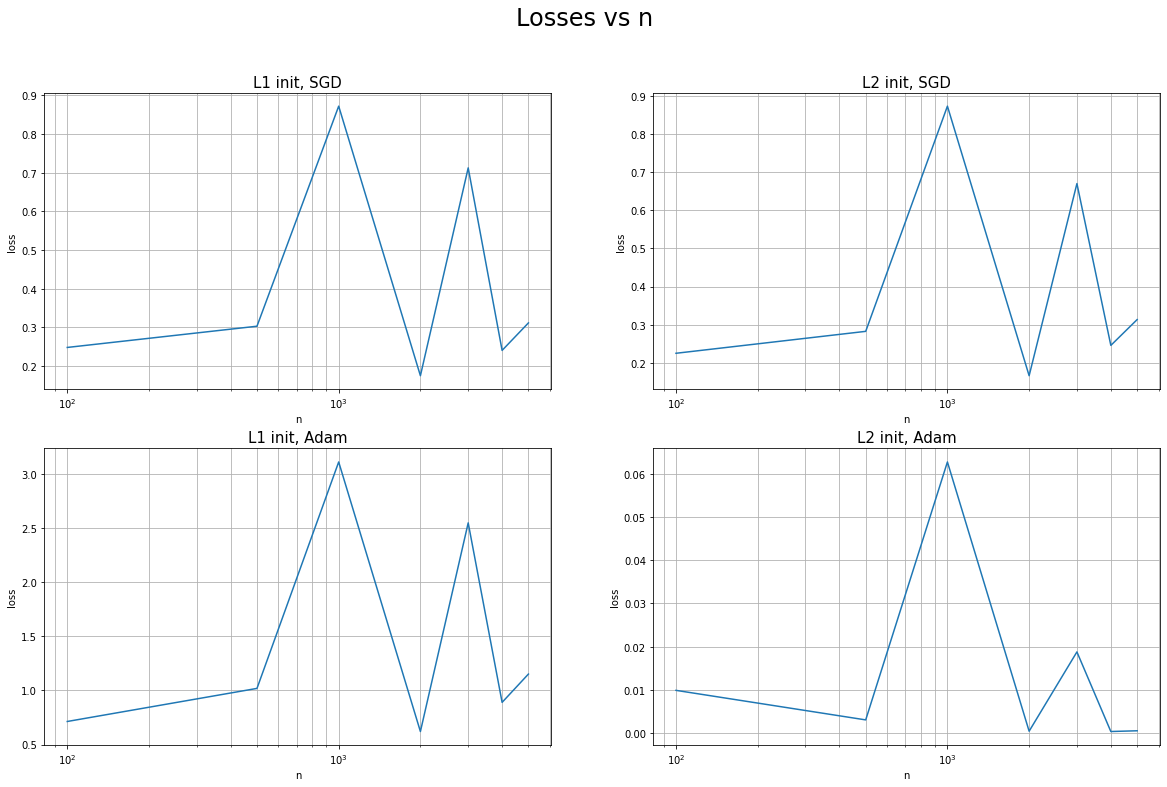

In [7]:
# plotting results

x=np.arange(100, 5000, 200)

fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(221)
ax1.semilogx(n_sizes, l1_loss_SGD)
plt.ylabel('loss')
plt.xlabel('n')
ax1.set_title("L1 init, SGD", fontsize=15)
ax1.grid(True, which="both")

ax2 = fig.add_subplot(222)
ax2.semilogx(n_sizes, l2_loss_SGD)
plt.ylabel('loss')
plt.xlabel('n')
ax2.set_title("L2 init, SGD", fontsize=15)
ax2.grid(True, which="both")

ax3 = fig.add_subplot(223)
ax3.semilogx(n_sizes, l1_loss_ADAM)
plt.ylabel('loss')
plt.xlabel('n')
ax3.set_title("L1 init, Adam", fontsize=15)
ax3.grid(True, which="both")

ax4 = fig.add_subplot(224)
ax4.semilogx(n_sizes, l2_loss_ADAM)
plt.ylabel('loss')
plt.xlabel('n')
ax4.set_title("L2 init, Adam", fontsize=15)
ax4.grid(True, which="both")

fig.suptitle("Losses vs n", fontsize=24)



Text(0.5, 0.98, 'Losses vs n')

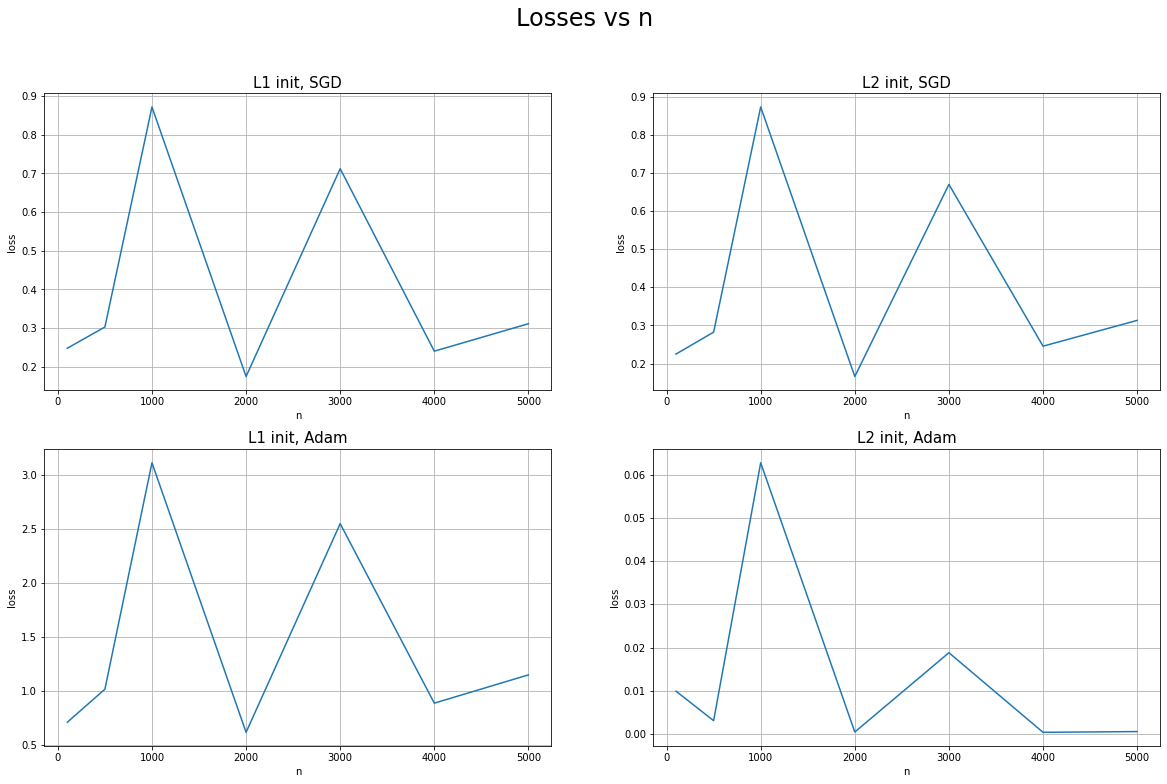

In [8]:
# plotting results

x=n_sizes

fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(221)
ax1.plot(x, l1_loss_SGD)
plt.ylabel('loss')
plt.xlabel('n')
ax1.set_title("L1 init, SGD", fontsize=15)
ax1.grid()

ax2 = fig.add_subplot(222)
ax2.plot(x, l2_loss_SGD)
plt.ylabel('loss')
plt.xlabel('n')
ax2.set_title("L2 init, SGD", fontsize=15)
ax2.grid()

ax3 = fig.add_subplot(223)
ax3.plot(x, l1_loss_ADAM)
plt.ylabel('loss')
plt.xlabel('n')
ax3.set_title("L1 init, Adam", fontsize=15)
ax3.grid()

ax4 = fig.add_subplot(224)
ax4.plot(x, l2_loss_ADAM)
plt.ylabel('loss')
plt.xlabel('n')
ax4.set_title("L2 init, Adam", fontsize=15)
ax4.grid()

fig.suptitle("Losses vs n", fontsize=24)
